Model Work

In [1]:
! git clone https://www.github.com/awhitehouse1/project_voting/

Cloning into 'project_voting'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 106 (delta 20), reused 34 (delta 15), pack-reused 64
Receiving objects: 100% (106/106), 32.62 MiB | 6.63 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Updating files: 100% (47/47), done.


In [2]:
!pip3 install mapclassify

In [3]:
import pandas as pd
import geopandas as gpd
import mapclassify
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:

gdf = gpd.read_file('/content/drive/My Drive/VirginiaCounty_ClippedToShoreline.shx') # Load Virginia shapefile for maps
vdf = pd.read_csv('./project_voting/clean_data/clean_vdf.csv')
cdf = pd.read_csv('./project_voting/clean_data/clean_cdf.csv')
nhgis = pd.read_csv('./project_voting/clean_data/clean_NHGIS_county_data.csv')

merged_df = pd.merge(vdf, cdf, left_on='county_fips', right_on='FIPS', how='left')

In [41]:
#standardize county names in gdf
gdf['NAME'] = gdf['NAME'].str.replace(' County', '')  # Remove 'County' from county names

#standardize county names in merged_df
merged_df['county_name'] = merged_df['county_name'].str.upper()  # Convert county names to uppercase

#names in gdf uppercase
gdf['NAME'] = gdf['NAME'].str.upper()

#names in merged_df uppercase
merged_df['county_name'] = merged_df['county_name'].str.upper()

#remove spaces between words in county names in gdf
gdf['NAME'] = gdf['NAME'].str.replace(' ', '')

#remove spaces between words in county names in merged_df
merged_df['county_name'] = merged_df['county_name'].str.replace(' ', '')

#unique county names from gdf and merged_df
unique_county_names_gdf = gdf['NAME'].unique()
unique_county_names_merged_df = merged_df['county_name'].unique()

common_county_names = set(unique_county_names_gdf) & set(unique_county_names_merged_df)

unique_county_names_gdf_only = set(unique_county_names_gdf) - common_county_names
unique_county_names_merged_df_only = set(unique_county_names_merged_df) - common_county_names

print("Common county names between datasets:", common_county_names)
print("County names unique to gdf:", unique_county_names_gdf_only)
print("County names unique to merged_df:", unique_county_names_merged_df_only)



Common county names between datasets: {'HANOVER', 'ROANOKE', 'FALLSCHURCH', 'DICKENSON', 'FREDERICKSBURG', 'ALEXANDRIA', 'HAMPTON', 'PETERSBURG', 'WARREN', 'MANASSAS', 'AUGUSTA', 'SALEM', 'RICHMOND', 'GOOCHLAND', 'WISE', 'KINGGEORGE', 'SCOTT', 'ACCOMACK', 'WILLIAMSBURG', 'SMYTH', 'RUSSELL', 'APPOMATTOX', 'LUNENBURG', 'PAGE', 'CHESTERFIELD', 'NEWKENT', 'RADFORD', 'SHENANDOAH', 'PRINCEWILLIAM', 'AMHERST', 'FREDERICK', 'LOUDOUN', 'SUFFOLK', 'GREENSVILLE', 'MATHEWS', 'ROCKINGHAM', 'CUMBERLAND', 'BATH', 'FRANKLIN', 'WYTHE', 'FAUQUIER', 'AMELIA', 'NORTON', 'GALAX', 'KINGANDQUEEN', 'COVINGTON', 'HOPEWELL', 'SUSSEX', 'ORANGE', 'ISLEOFWIGHT', 'BRISTOL', 'BUENAVISTA', 'CHESAPEAKE', 'CHARLOTTE', 'COLONIALHEIGHTS', 'MARTINSVILLE', 'JAMESCITY', 'ROCKBRIDGE', 'MECKLENBURG', 'PITTSYLVANIA', 'PATRICK', 'STAUNTON', 'POWHATAN', 'MIDDLESEX', 'HENRY', 'POQUOSON', 'CRAIG', 'FLOYD', 'ALBEMARLE', 'GRAYSON', 'ESSEX', 'MANASSASPARK', 'SOUTHAMPTON', 'CHARLESCITY', 'SURRY', 'LYNCHBURG', 'CAROLINE', 'MADISON', 'L

In [42]:
#merge shapefile and merged_df
gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
df = gdf.merge(merged_df,left_on='FIPS_left',right_on='county_fips')
virginia_data = nhgis[nhgis['state'] == 'Virginia']

In [43]:
#previous election data
vdf_previous_election = vdf.loc[ vdf['year']==2020,:]
Rvotes = vdf_previous_election.loc[(vdf_previous_election['party']=='REPUBLICAN'),:].groupby('county_fips')['candidatevotes'].sum()
Rvotes = Rvotes.rename('repub_2020')
Dvotes = vdf_previous_election.loc[(vdf_previous_election['party']=='DEMOCRAT'),:].groupby('county_fips')['candidatevotes'].sum()
Dvotes = Dvotes.rename('dem_2020')
Dvotes_index = Dvotes.index
FIP = Dvotes_index.tolist()
print(FIP)
virginia_data['county_fips'] = FIP
virginia_data = virginia_data.merge(Dvotes,left_on='county_fips',right_on='county_fips')
virginia_data = virginia_data.merge(Rvotes,left_on='county_fips',right_on='county_fips')
print(virginia_data)

[51001, 51003, 51005, 51007, 51009, 51011, 51013, 51015, 51017, 51019, 51021, 51023, 51025, 51027, 51029, 51031, 51033, 51035, 51036, 51037, 51041, 51043, 51045, 51047, 51049, 51051, 51053, 51057, 51059, 51061, 51063, 51065, 51067, 51069, 51071, 51073, 51075, 51077, 51079, 51081, 51083, 51085, 51087, 51089, 51091, 51093, 51095, 51097, 51099, 51101, 51103, 51105, 51107, 51109, 51111, 51113, 51115, 51117, 51119, 51121, 51125, 51127, 51131, 51133, 51135, 51137, 51139, 51141, 51143, 51145, 51147, 51149, 51153, 51155, 51157, 51159, 51161, 51163, 51165, 51167, 51169, 51171, 51173, 51175, 51177, 51179, 51181, 51183, 51185, 51187, 51191, 51193, 51195, 51197, 51199, 51510, 51520, 51530, 51540, 51550, 51570, 51580, 51590, 51595, 51600, 51610, 51620, 51630, 51640, 51650, 51660, 51670, 51678, 51680, 51683, 51685, 51690, 51700, 51710, 51720, 51730, 51735, 51740, 51750, 51760, 51770, 51775, 51790, 51800, 51810, 51820, 51830, 51840]
        state             county  M_18_to_29  M_30_to_49  M_50_to_64

<ipython-input-43-07a0468f0a38>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  virginia_data['county_fips'] = FIP


In [60]:
cats = ['M_18_to_29', 'M_30_to_49', 'M_50_to_64', 'M_65_plus', 'F_18_to_29', 'F_30_to_49', 'F_50_to_64', 'F_65_plus', 'income_under_30000', 'income_30000_to_49999', 'income_50000_to_99999', 'income_100000_plus']

for cat in cats:
    virginia_data[cat] = pd.to_numeric(virginia_data[cat], errors='coerce')

#linear regression
X_numeric = virginia_data[cats]
y = virginia_data[['dem_2020','repub_2020']]
X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)
linear_reg_numeric = LinearRegression()
linear_reg_numeric.fit(X_train_numeric, y_train)
#training and testing data
y_train_pred_numeric = linear_reg_numeric.predict(X_train_numeric)
y_test_pred_numeric = linear_reg_numeric.predict(X_test_numeric)
#rmse, R^2, and MAE
train_rmse_numeric = np.sqrt(mean_squared_error(y_train, y_train_pred_numeric))
test_rmse_numeric = np.sqrt(mean_squared_error(y_test, y_test_pred_numeric))
train_r2_numeric = r2_score(y_train, y_train_pred_numeric)
test_r2_numeric = r2_score(y_test, y_test_pred_numeric)
test_mae = mean_absolute_error(y_test, y_test_pred_numeric)
print('Train RMSE:', train_rmse_numeric, 'R^2:', train_r2_numeric)
print('Test RMSE:', test_rmse_numeric, 'R^2:', test_r2_numeric)
print('Test MAE:', test_mae)


Train RMSE: 3461.737017783332 R^2: 0.9839043292786235
Test RMSE: 4022.6980891680023 R^2: 0.9089262880380649
Test MAE: 2602.092297917564


Plots to visualize

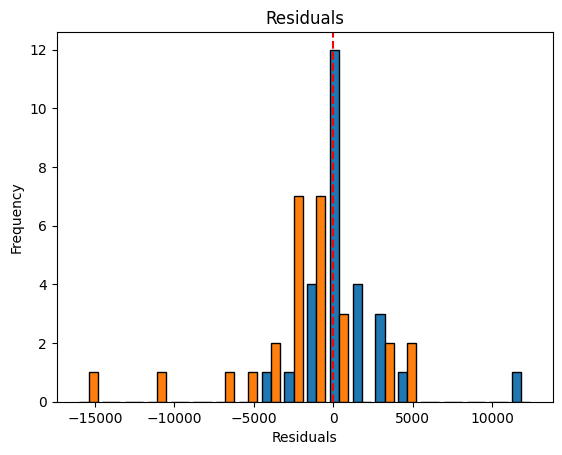

In [45]:
residuals = y_test - y_test_pred_numeric
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()


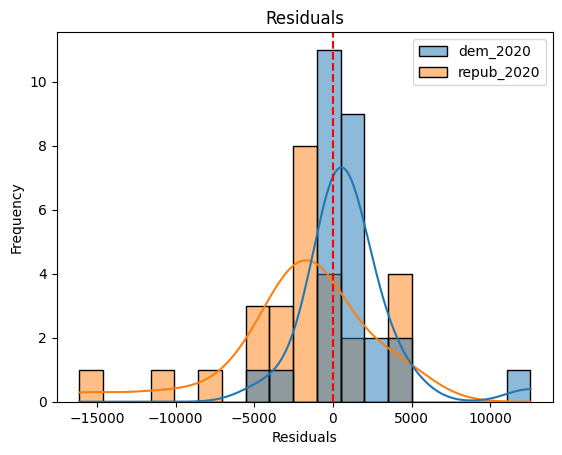

In [46]:
#residuals plot
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

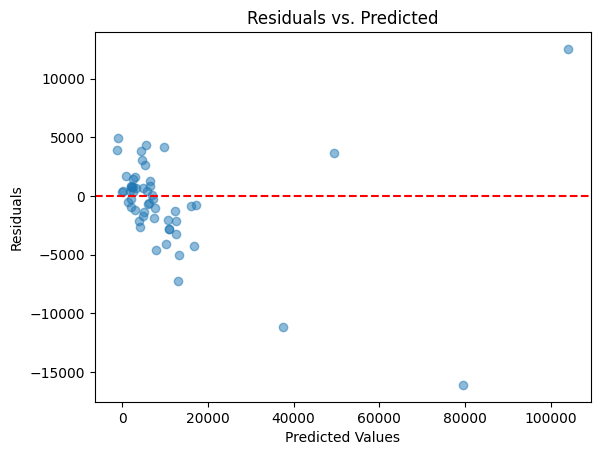

In [47]:
#scatter plot
plt.scatter(y_test_pred_numeric, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


In [48]:
#predicted 2024
df = df.merge(Rvotes,left_on='FIPS_left',right_on='county_fips')
df = df.merge(Dvotes,left_on='FIPS_left',right_on='county_fips')

In [49]:
y_pred_numeric = linear_reg_numeric.predict(X_numeric)
predicted_votes = pd.DataFrame(y_pred_numeric, columns=['Dem_2024', 'Repub_2024'])
df = pd.concat([df, predicted_votes], axis=1)

In [50]:
df['vote_difference'] = df['Dem_2024'] - df['Repub_2024']

In [51]:
df.head()

,STCOFIPS,GNIS,NAME,NAMELSAD,GSOURCE,LADOPT,LASTUPDATE,JURISTYPE,AREASQMI,Shape_Leng,...,N8,N9,N10,N11,N12,repub_2020,dem_2020,Dem_2024,Repub_2024,vote_difference
0,51001,1480091,ACCOMACK,Accomack County,T,N,2014-08-20,CO,1195.366291,4949956.957,...,NaN,NaN,NaN,NaN,NaN,9172,7578,6043.223577,12738.784069,-6695.560492
1,51001,1480091,ACCOMACK,Accomack County,T,N,2014-08-20,CO,1195.366291,4949956.957,...,NaN,NaN,NaN,NaN,NaN,9172,7578,35709.703909,21992.155210,13717.548699
2,51001,1480091,ACCOMACK,Accomack County,T,N,2014-08-20,CO,1195.366291,4949956.957,...,NaN,NaN,NaN,NaN,NaN,9172,7578,2440.644800,7004.917493,-4564.272693
3,51001,1480091,ACCOMACK,Accomack County,T,N,2014-08-20,CO,1195.366291,4949956.957,...,NaN,NaN,NaN,NaN,NaN,9172,7578,2393.433027,5142.243880,-2748.810853
4,51001,1480091,ACCOMACK,Accomack County,T,N,2014-08-20,CO,1195.366291,4949956.957,...,NaN,NaN,NaN,NaN,NaN,9172,7578,6266.107159,12331.999319,-6065.892160


In [52]:
#specific columns
selected_columns = ['NAME', 'Dem_2024', 'Repub_2024', 'vote_difference']

table_df = df.loc[:, selected_columns]


In [53]:
#grouping by name and sum votes
county_diff = df.groupby('NAME').agg({
    'Dem_2024': 'sum',
    'Repub_2024': 'sum',
    'vote_difference': 'sum'
}).reset_index()

In [54]:
#aggregation function to count positive, negative, and zero vote differences
def count_positive_negative_zero(x):
    positive_count = np.sum(x > 0)
    negative_count = np.sum(x < 0)
    zero_count = np.sum(x == 0)
    return pd.Series([positive_count, negative_count, zero_count], index=['positive_count', 'negative_count', 'zero_count'])

county_diff_counts = county_diff['vote_difference'].apply(count_positive_negative_zero)

total_positive_count = county_diff_counts['positive_count'].sum()
total_negative_count = county_diff_counts['negative_count'].sum()
total_zero_count = county_diff_counts['zero_count'].sum()

print("Total counties with positive vote difference:", total_positive_count)
print("Total counties with negative vote difference:", total_negative_count)
print("Total counties with zero vote difference:", total_zero_count)

Total counties with positive vote difference: 5
Total counties with negative vote difference: 4
Total counties with zero vote difference: 120



Tried VA plots but not enough 2024 data

<Axes: >

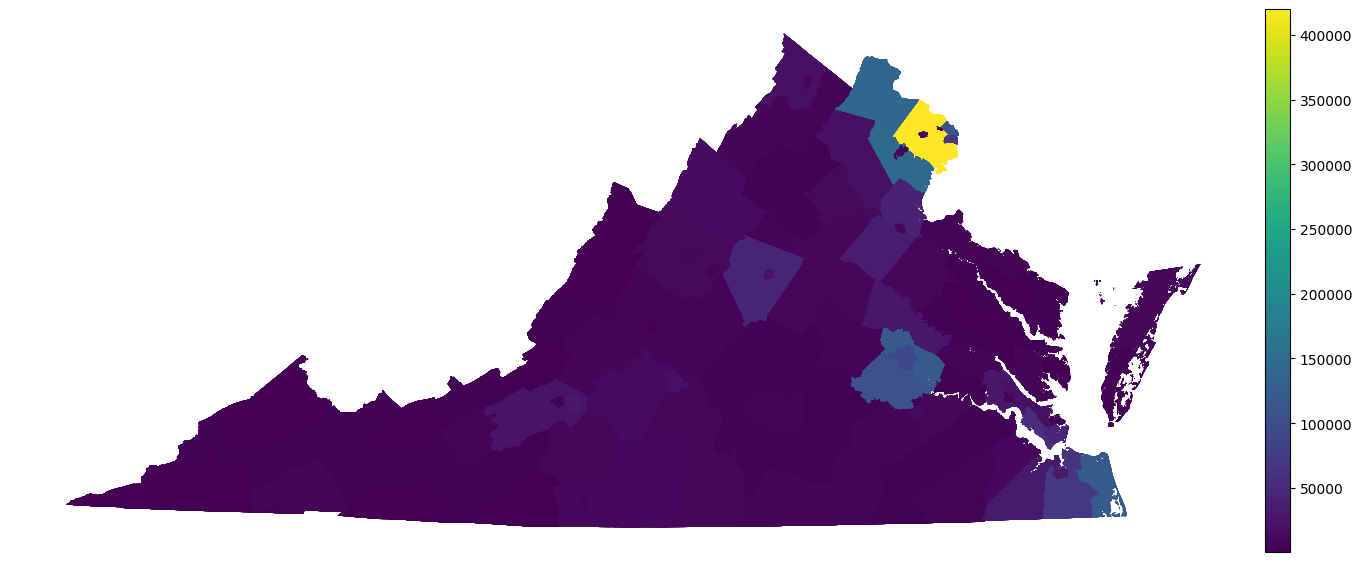

In [56]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='dem_2020',legend=True,cax=cax)

<Axes: >

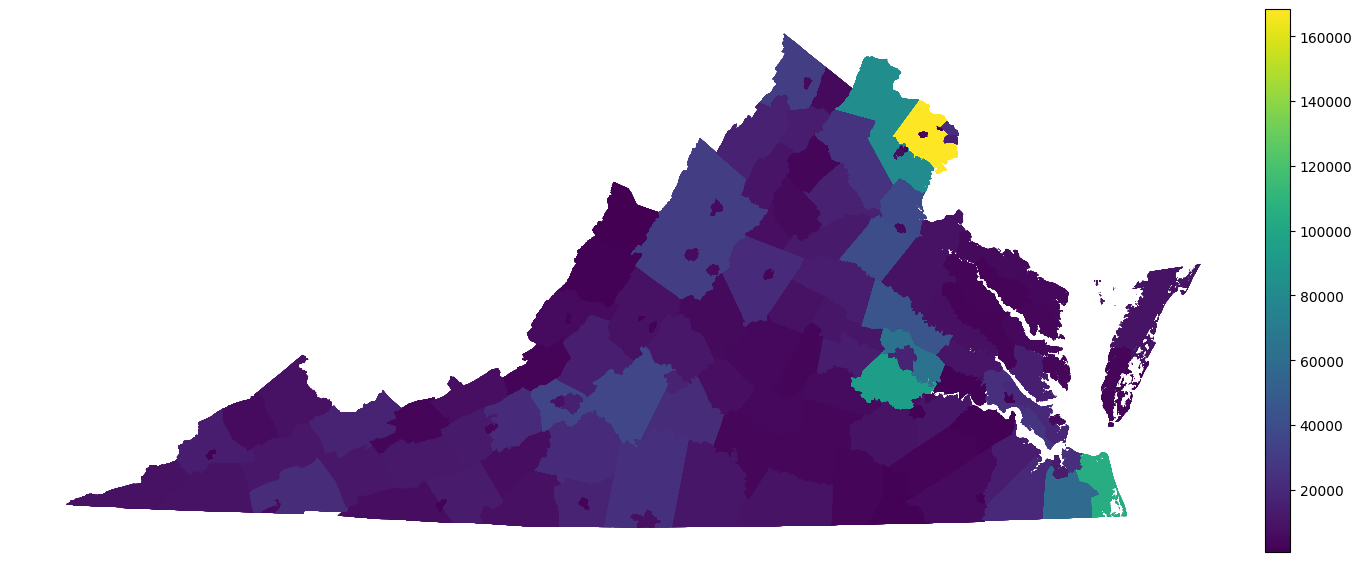

In [57]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='repub_2020',legend=True,cax=cax)

<Axes: >

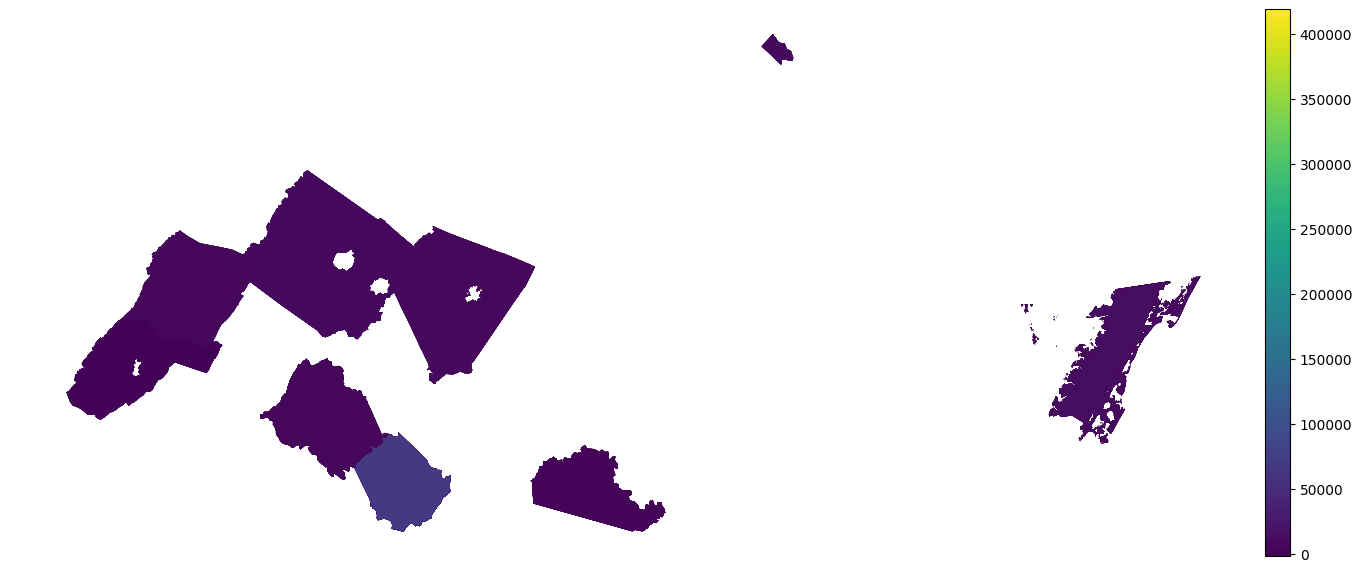

In [58]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='Dem_2024',legend=True,cax=cax)

<Axes: >

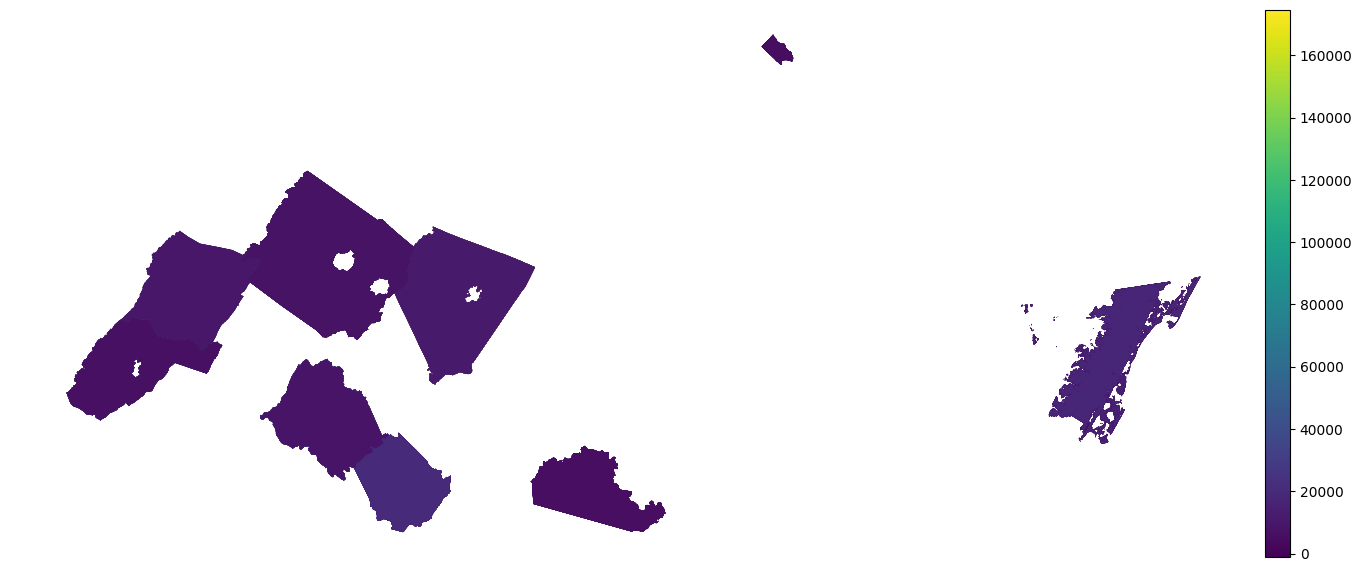

In [59]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='Repub_2024',legend=True,cax=cax)